In [18]:
#Initailize the LLM with Groq
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq

load_dotenv()  # loads environment variables from .env

llm = ChatGroq(model_name="openai/gpt-oss-20b", api_key=os.getenv("GROQ_API_KEY"))

llm.invoke("Hello, diff between cursor vs vscode?")


AIMessage(content='**Cursor vs. VS\u202fCode – A quick‑look comparison**\n\n| Feature | Cursor | VS\u202fCode |\n|---------|--------|---------|\n| **Core** | Built on top of the VS\u202fCode engine (Electron + Monaco) but wrapped in a custom UI layer. | Native VS\u202fCode engine (Electron + Monaco). |\n| **UI/UX** | • Clean, minimalistic layout with a “chat‑first” sidebar. <br>• One‑click “Open in Chat” for context‑aware AI help. <br>• Dark‑mode‑first design with fewer distractions. | • Classic VS\u202fCode layout (Explorer, Search, Source Control, Run, Extensions). <br>• Highly configurable via settings, keybindings, and themes. |\n| **AI Integration** | • Built‑in, always‑on AI assistant (ChatGPT‑style) that can write, explain, refactor, and even run code. <br>• AI can be triggered via a single button or automatically in the context of the file. | • AI features are available only through extensions (e.g., GitHub Copilot, Tabnine, Kite). <br>• No native chat UI; you install the exten

In [19]:
#Initailize the LLM with OpenAI
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI#llm creation
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.environ.get("OPEN_API_KEY")

#llm creation
openAillm = ChatOpenAI(model_name="gpt-3.5-turbo")
openAillm.invoke("Hello, diff between cursor vs vscode?")

AIMessage(content='Both cursor and Visual Studio Code (VSCode) are commonly used in programming environments, but they serve different functions.\n\n1. Cursor:\n- The cursor is a blinking line or block that indicates the current location or position of the text input field in a document or text editor.\n- It can be moved using the arrow keys or mouse to navigate through text, select text, or make edits.\n- The cursor is a basic feature found in almost all text editors and word processing software.\n- It is used for text input and manipulation within a document.\n\n2. Visual Studio Code (VSCode):\n- Visual Studio Code is a powerful and feature-rich source code editor developed by Microsoft.\n- It is highly customizable and supports a wide range of programming languages and extensions.\n- VSCode provides advanced features such as syntax highlighting, code completion, debugging, and version control integration.\n- It offers a more comprehensive environment for software development compare

In [20]:
# define the tools
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

api_wrapper_wiki = WikipediaAPIWrapper(tool_k_results=1, doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
##To test run the wiki tool
# print(wiki.invoke("hello world program"))
llm_with_tools = llm.bind_tools([wiki])

In [30]:
#lang graph imports
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage ## human or ai messages
from typing import Annotated ## for labelling the messages
from langgraph.graph.message import add_messages ## reducers for messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display ## for graph visualization
from langgraph.checkpoint.memory import MemorySaver

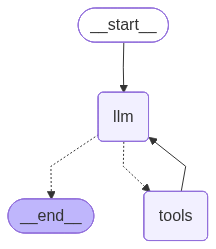

In [37]:
## lang graph initializ

## langgraph state creation
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages] 

## Node creation
def llm_node(state: State) -> State:
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

## graph creation
graph_builder = StateGraph(State)

# add nodes to the graph
graph_builder.add_node("llm", llm_node)
graph_builder.add_node("tools", ToolNode(tools=[wiki]))

# add edges to the graph
graph_builder.add_edge(START, "llm")
graph_builder.add_conditional_edges(
    "llm",
    tools_condition,
    {
        "tools": "tools",
        "__end__": END
    }
)
graph_builder.add_edge("tools", "llm")

## by default the memory will be shared in only one session (starting the graph => end graph)
#graph = graph_builder.compile()

# to make the memory across the sessions need (memory = MemorySaver())
memory = MemorySaver()
graph = graph_builder.compile(memory)

#View the graph
display(Image(graph.get_graph().draw_mermaid_png()))
    

In [ ]:
#### if the below code throws an error, uncomment graph = graph_builder.compile()
#### if you invoke with without memory saver the below example will not work (expected output will not get)
messages = graph.invoke({"messages": "tell me about tamil language"});

for msg in messages["messages"]:
    msg.pretty_print()

#now we are invoking the llm with new session, so existing doesn't know,it will not answer
messages = graph.invoke({"messages": "how old is?"});
print("*******************************")
for msg in messages["messages"]:
    msg.pretty_print()

================================ Human Message =================================

tell me about tamil language
================================== Ai Message ==================================
Tool Calls:
  wikipedia (fc_bd034a09-fc64-44c5-b260-ef215738feb3)
 Call ID: fc_bd034a09-fc64-44c5-b260-ef215738feb3
  Args:
    query: Tamil language
================================= Tool Message =================================
Name: wikipedia

Page: Tamil language
Summary: Tamil (தமிழ், Tamiḻ, pronounced [t̪amiɻ] , is a Dravidian language natively spoken by the Tamil people of South Asia. It is one of the longest-surviving classical languages in the world, attested since c. 300 BCE.
Tamil was the lingua franca for early maritime traders in South India, with Tamil inscriptions found outside of the Indian subcontinent, such as Indonesia, Thailand, and Egypt. The language has a well-documented history with literary works like Sangam lite
================================== Ai Message =============

In [ ]:
#### if the below code throws an error, uncomment (memory = MemorySaver() graph = graph_builder.compile(memory) )
#### this will work just opposite to above example, the context will be shared for across the session based on session_id
thread_id = "session_001"
messages = graph.invoke({"messages": "tell me about tamil language"}, config={"thread_id": thread_id});

for msg in messages["messages"]:
    msg.pretty_print()

#now we are invoking the llm with new session, so existing doesn't know,it will not answer
messages = graph.invoke({"messages": "how old is?"}, config={"thread_id": thread_id});
print("*******************************")
for msg in messages["messages"]:
    msg.pretty_print()

================================ Human Message =================================

tell me about tamil language
================================== Ai Message ==================================
Tool Calls:
  wikipedia (fc_3d1b8f04-4c75-4d55-8f79-11cd76d0aada)
 Call ID: fc_3d1b8f04-4c75-4d55-8f79-11cd76d0aada
  Args:
    query: Tamil language
================================= Tool Message =================================
Name: wikipedia

Page: Tamil language
Summary: Tamil (தமிழ், Tamiḻ, pronounced [t̪amiɻ] , is a Dravidian language natively spoken by the Tamil people of South Asia. It is one of the longest-surviving classical languages in the world, attested since c. 300 BCE.
Tamil was the lingua franca for early maritime traders in South India, with Tamil inscriptions found outside of the Indian subcontinent, such as Indonesia, Thailand, and Egypt. The language has a well-documented history with literary works like Sangam lite
================================== Ai Message =============